In [1]:
%matplotlib inline
import torch
from torch import nn
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

import matplotlib.pyplot as plt
import numpy as np
import math, time


In [2]:
#Specify device 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
from torch.utils.data import DataLoader
from functions_geometry.get_dataset import MNISTRotated

train_data = MNISTRotated(path_to_data='./data/mnist_rot/train_all.npz')
test_data = MNISTRotated(path_to_data='./data/mnist_rot/test.npz')

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
# HYPERPARAMETERS
BATCH_SIZE = 64 #batch size of mini-batches for training, test
LEARNING_RATE = 1e-2
EPOCHS= 5
NROT = 4 # 4 rotations

In [5]:
from models.gcnn_mlp_classifier import GCNNMLPModel
# Create model, define loss, optimizer
torch.manual_seed(0)
model = GCNNMLPModel(bn_train=True, conv_bias=False, grouporder=NROT).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using mps device


In [6]:
model

GCNNMLPModel(
  (feature_extractor): Sequential(
    (0): GCNN_layer()
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): GCNN_layer()
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): GCNN_layer()
    (8): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): GCNN_layer()
    (11): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=2560, out_features=20, bias=True)
    (15): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
  )
  (classifier): Linear(in_features=20, out_features=10, bias=True)
)

In [7]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
print(num_trainable_params)

62680


In [8]:
from functions_geometry.utils import compute_manifold_properties
layer_types = ['GCNN_layer', 'MaxPool2d', 'Linear']
capacities_init, radii_init, dimensions_init, correlations_init, layernames_all =compute_manifold_properties(model, train_data, sampled_classes=10, \
                                                                                                             examples_per_class=50, layer_types=layer_types)

/Users/sumedh/miniconda3/envs/am220/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/sumedh/Library/CloudStorage/GoogleDrive-shindupurravindra@g.harvard.edu/My Drive/phd_harvard/coursework/spring 2024/am220/course_project/code_new/layers/gconvlayer.py:46: UserWarning: The operator 'aten::sinc.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  "ijkl, ijml -> ijkml", torch.special.sinc(tile_x / delta), torch.special.sinc(tile_y / delta)


Projecting layer_0_Input
Projecting layer_1_GCNN_layer
Projecting layer_4_GCNN_layer
Projecting layer_7_MaxPool2d
Projecting layer_8_GCNN_layer
Projecting layer_11_GCNN_layer
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.2014644901091325e+01    2.79322982e+00    
   2         +9.3383670048723442e+00    2.29890927e+00    
   3         +9.0589475552238614e+00    2.12828969e+00    
   4         +8.6486144350732133e+00    2.85855914e+00    
   5         +8.5719552748139378e+00    3.33062614e+00    
   6         +8.3660644890290747e+00    2.09240926e+00    
   7         +8.3036157068471539e+00    1.06853862e+00    
   8         +8.2821373406858463e+00    7.59425337e-01    
   9         +8.2634854983251742e+00    3.84106797e-01    
  10         +8.2586917649323759e+00    2.56129639e-01    
  11         +8.2571374208385286e+00    2.40541391e-01    
  12         +8.2554518402632890e+00    7.26

In [9]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [10]:
from functions_geometry.train_test import train, test

train_loss_epoch = [None for i in range(EPOCHS)]
test_loss_epoch = [None for i in range(EPOCHS)]

train_acc_epoch = [None for i in range(EPOCHS)]
test_acc_epoch = [None for i in range(EPOCHS)]


torch.manual_seed(0)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_epoch[t], train_acc_epoch[t] = train(train_dataloader, model, loss_fn, optimizer)
    if t==EPOCHS-1:
        test_loss_epoch[t], test_acc_epoch[t] = test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.348606, accuracy: 14.062500  [   64/12000]
loss: 1.704333, accuracy: 34.375000  [ 1344/12000]
loss: 1.334463, accuracy: 60.937500  [ 2624/12000]
loss: 0.959365, accuracy: 73.437500  [ 3904/12000]
loss: 1.028442, accuracy: 67.187500  [ 5184/12000]
loss: 0.824573, accuracy: 73.437500  [ 6464/12000]
loss: 0.605899, accuracy: 79.687500  [ 7744/12000]
loss: 0.407074, accuracy: 84.375000  [ 9024/12000]
loss: 0.608435, accuracy: 81.250000  [10304/12000]
loss: 0.449902, accuracy: 87.500000  [11584/12000]
Epoch 2
-------------------------------
loss: 0.361685, accuracy: 89.062500  [   64/12000]
loss: 0.437546, accuracy: 85.937500  [ 1344/12000]
loss: 0.545777, accuracy: 81.250000  [ 2624/12000]
loss: 0.456654, accuracy: 85.937500  [ 3904/12000]
loss: 0.507749, accuracy: 81.250000  [ 5184/12000]
loss: 0.749881, accuracy: 82.812500  [ 6464/12000]
loss: 0.238281, accuracy: 90.625000  [ 7744/12000]
loss: 0.256945, accuracy: 92.187500  [ 9024/12000]
lo

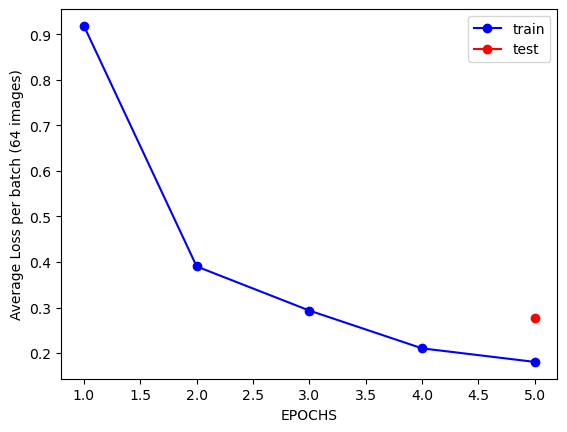

In [11]:
plt.plot(torch.arange(1,EPOCHS+1), [torch.mean(torch.tensor(train_loss_epoch[k])) for k in range(EPOCHS)], 'bo-', label='train')
plt.plot(torch.arange(1,EPOCHS+1), test_loss_epoch, 'ro-', label='test')
plt.xlabel("EPOCHS")
plt.ylabel("Average Loss per batch (64 images)")
plt.legend()

In [12]:
#save model weights
# torch.save(model.state_dict(), './results/gcnn4_mlp_model_weights.pth')

In [13]:
capacities_final, radii_final, dimensions_final, correlations_final, layernames_all =compute_manifold_properties(model, train_data, sampled_classes=10, examples_per_class=50, layer_types=layer_types)

Projecting layer_0_Input
Projecting layer_1_GCNN_layer
Projecting layer_4_GCNN_layer
Projecting layer_7_MaxPool2d
Projecting layer_8_GCNN_layer
Projecting layer_11_GCNN_layer
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.2014644901091325e+01    2.79322982e+00    
   2         +9.3383670048723442e+00    2.29890927e+00    
   3         +9.0589475552238614e+00    2.12828969e+00    
   4         +8.6486144350732133e+00    2.85855914e+00    
   5         +8.5719552748139378e+00    3.33062614e+00    
   6         +8.3660644890290747e+00    2.09240926e+00    
   7         +8.3036157068471539e+00    1.06853862e+00    
   8         +8.2821373406858463e+00    7.59425337e-01    
   9         +8.2634854983251742e+00    3.84106797e-01    
  10         +8.2586917649323759e+00    2.56129639e-01    
  11         +8.2571374208385286e+00    2.40541391e-01    
  12         +8.2554518402632890e+00    7.26

In [15]:
# np.savez('./results/gcnn4_mlp_objmanifolds_allclasses.npz', capacities_init=capacities_init, radii_init=radii_init, dimensions_init=dimensions_init, correlations_init=correlations_init,\
#          capacities_final=capacities_final, radii_final=radii_final, dimensions_final=dimensions_final, correlations_final=correlations_final, layernames_all=list(layernames_all))